In [189]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import acquire
import prepare

import matplotlib.pyplot as plt
from env import host, user, password
from pydataset import data
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
# import logistic_regression_util
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from matplotlib.colors import ListedColormap

In [190]:
from acquire import get_telco_data

### Acquire Telco data from SQL Database

Here I will acquire the Telco churn database from SQL Ace

In [191]:
# Pull data and see the information that we are working with on the data pulled
df = get_telco_data()
df.head(3)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)


In [192]:
## see how many columns and rows we are working with
df.shape

(7043, 24)

In [193]:
df.value_counts()

payment_type_id  internet_service_type_id  contract_type_id  customer_id  gender  senior_citizen  partner  dependents  tenure  phone_service  multiple_lines  online_security      online_backup        device_protection    tech_support         streaming_tv         streaming_movies     paperless_billing  monthly_charges  total_charges  churn  contract_type   internet_service_type  payment_type             
4                3                         3                 9975-GPKZU   Male    0               Yes      Yes         46      Yes            No              No internet service  No internet service  No internet service  No internet service  No internet service  No internet service  No                 19.75            856.5          No     Two year        None                   Credit card (automatic)      1
1                3                         3                 4475-NVTLU   Male    0               Yes      Yes         45      Yes            No              No internet service  No

### Prepare

#### Data Preparation

- Explore missing values and document takeaways/action plans for handling them.
  - Is 'missing' equivalent to 0 (or some other constant value) in the specific case of this variable?
  - Should you replace the missing values with a value it is most likely to represent, like mean/median/mode?
  - Should you remove the variable (column) altogether because of the percentage of missing data?
  - Should you remove individual observations (rows) with a missing value for that variable?
- Explore data types and adapt types or data values as needed to have numeric represenations of each attribute.
- Create any new features you want to use in your model. Some ideas you might want to explore after securing a MVP:
  - Create a new feature that represents tenure in years.
  - Create single variables for or find other methods to merge variables representing the information from the following columns:
    - phone_service and multiple_lines
    - dependents and partner
    - streaming_tv & streaming_movies
    - online_security & online_backup
- Import your prepare function from your prepare.py module and use it to prepare your data in your notebook.

In [173]:
# Then we will get information about the dataframe: columns, rows, datatypes, non-missing values

In [174]:
# review what types of data we are working with
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [177]:
# Here we will get the statistical data
df[['tenure','monthly_charges']].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


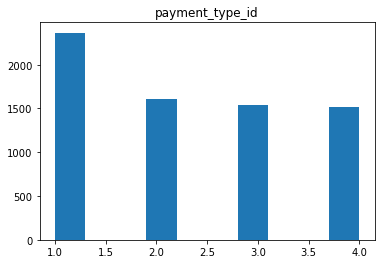

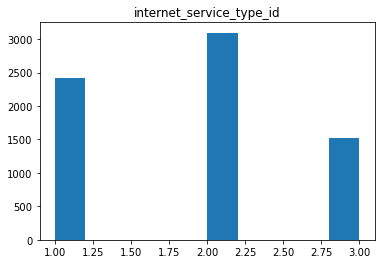

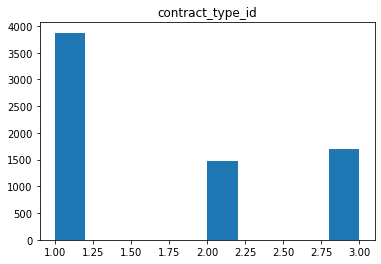

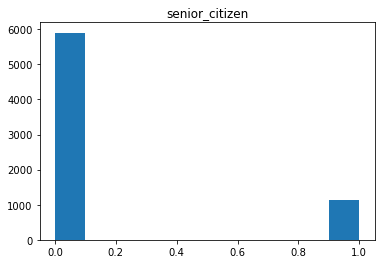

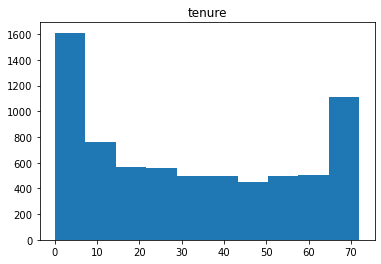

In [63]:
# Check out the distributions of numeric columns - these are the categorical variables
num_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [10]:

obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
for col in obj_cols:
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------')

3090-HAWSU    1
1353-LJWEM    1
3001-UNBTL    1
0222-CNVPT    1
3129-AAQOU    1
             ..
7963-SHNDT    1
8468-EHYJA    1
6248-BSHKG    1
0947-IDHRQ    1
8680-CGLTP    1
Name: customer_id, Length: 7043, dtype: int64
3090-HAWSU    0.000142
1353-LJWEM    0.000142
3001-UNBTL    0.000142
0222-CNVPT    0.000142
3129-AAQOU    0.000142
                ...   
7963-SHNDT    0.000142
8468-EHYJA    0.000142
6248-BSHKG    0.000142
0947-IDHRQ    0.000142
8680-CGLTP    0.000142
Name: customer_id, Length: 7043, dtype: float64
----------------------
Male      3555
Female    3488
Name: gender, dtype: int64
Male      0.504756
Female    0.495244
Name: gender, dtype: float64
----------------------
No     3641
Yes    3402
Name: partner, dtype: int64
No     0.516967
Yes    0.483033
Name: partner, dtype: float64
----------------------
No     4933
Yes    2110
Name: dependents, dtype: int64
No     0.700412
Yes    0.299588
Name: dependents, dtype: float64
----------------------
Yes    6361
No      682
Nam

## Clean the data

In [15]:
# Drop duplicates

df = df.drop_duplicates()
df.shape

(7043, 24)

In [21]:
# change total_charges to float
df['total_charges'] = df['total_charges'] + '0'

In [22]:
df['total_charges'] = df['total_charges'].astype('float')

In [23]:
# Find the names of the columns
col_list = list(df.select_dtypes('object').columns)[1:]
col_list

['gender',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type']

In [24]:
pd.get_dummies(df[col_list])

,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phone_service_No,phone_service_Yes,multiple_lines_No,multiple_lines_No phone service,...,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,1,0,0,1,0,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,1
1,0,1,1,0,1,0,1,0,0,1,...,0,0,1,1,0,0,0,1,0,0
2,1,0,1,0,1,0,1,0,0,1,...,0,0,1,1,0,0,1,0,0,0
3,0,1,0,1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,1,0,0
4,0,1,0,1,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,1,0,1,0,1,1,0,...,1,0,0,0,0,1,0,0,0,1
7039,1,0,1,0,1,0,0,1,1,0,...,1,0,0,0,0,1,0,0,0,1
7040,1,0,1,0,1,0,0,1,1,0,...,1,0,0,0,0,1,0,1,0,0
7041,0,1,1,0,1,0,0,1,1,0,...,1,0,0,0,0,1,0,0,0,1


In [25]:
# creating dummy dataframe
dummy_df = pd.get_dummies(df[col_list])
dummy_df.head(3)

,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phone_service_No,phone_service_Yes,multiple_lines_No,multiple_lines_No phone service,...,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,1,0,0,1,0,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,1
1,0,1,1,0,1,0,1,0,0,1,...,0,0,1,1,0,0,0,1,0,0
2,1,0,1,0,1,0,1,0,0,1,...,0,0,1,1,0,0,1,0,0,0


In [179]:
# combining original dataframe with dummy dataframe
df = pd.concat([df, dummy_df], axis=1)
df.head(3)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,monthly_charges,tenure
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,1,1,0,0,0,0,0,1,90.45,65
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,1,1,0,0,0,1,0,0,45.20,54
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,1,1,0,0,1,0,0,0,45.05,56


In [180]:
# for the two numerical variables monthly_charges and tenure, we dont see any evidence of relationship
df[['monthly_charges', 'tenure']].corr()

,monthly_charges,monthly_charges,tenure,tenure
monthly_charges,1.0000,1.0000,0.2479,0.2479
monthly_charges,1.0000,1.0000,0.2479,0.2479
tenure,0.2479,0.2479,1.0000,1.0000
tenure,0.2479,0.2479,1.0000,1.0000


In [181]:
# creating correlation table
df_corr = df.corr().reset_index()
df_corr.head()

,index,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges,gender_Female,gender_Male,partner_No,...,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,monthly_charges,tenure
0,payment_type_id,1.000000,0.008124,0.358913,-0.093704,0.340305,-0.074353,0.005209,-0.005209,-0.133115,...,0.295762,0.088956,-0.182323,0.117102,0.315658,0.769806,-0.814266,-0.149682,-0.074353,0.340305
1,internet_service_type_id,0.008124,1.000000,0.099721,-0.032310,-0.030359,-0.323260,0.000863,-0.000863,-0.000891,...,0.101475,-0.856353,0.152555,0.803477,-0.017581,-0.032540,-0.091881,0.152481,-0.323260,-0.030359
2,contract_type_id,0.358913,0.099721,1.000000,-0.142554,0.671607,-0.074195,-0.000126,0.000126,-0.294806,...,0.884292,0.055352,-0.254157,0.242388,0.186440,0.210659,-0.342575,-0.004882,-0.074195,0.671607
3,senior_citizen,-0.093704,-0.032310,-0.142554,1.000000,0.016567,0.220173,0.001874,-0.001874,-0.016479,...,-0.117000,-0.108322,0.255338,-0.182742,-0.016159,-0.024135,0.171718,-0.153477,0.220173,0.016567
4,tenure,0.340305,-0.030359,0.671607,0.016567,1.000000,0.247900,-0.005106,0.005106,-0.379697,...,0.558533,0.013274,0.019720,-0.039062,0.243510,0.233006,-0.208363,-0.233852,0.247900,1.000000


In [182]:
# rename columns in correlation table
df_corr.rename(columns={'index': 'col_names'}, inplace=True)

In [45]:
# Filer columns to only churn_no and churn_yes and transpose table
df_corr= df_corr[(df_corr.col_names=='churn_No') | (df_corr.col_names=='churn_Yes')].T.reset_index()

In [46]:
df_corr.columns

Index(['index', 38, 39], dtype='object')

In [47]:
df_corr= df_corr.rename(columns={38:"churn_No", 39: "churn_Yes"})

In [48]:
df_corr= df_corr.drop([0], axis=0)

In [49]:
df_corr.sort_values(by='churn_No')

,index,churn_No,churn_Yes
40,churn_Yes,-1,1
41,contract_type_Month-to-month,-0.405103,0.405103
19,online_security_No,-0.342637,0.342637
28,tech_support_No,-0.337281,0.337281
45,internet_service_type_Fiber optic,-0.30802,0.30802
49,payment_type_Electronic check,-0.301919,0.301919
22,online_backup_No,-0.268005,0.268005
25,device_protection_No,-0.252481,0.252481
6,monthly_charges,-0.193356,0.193356
38,paperless_billing_Yes,-0.191825,0.191825


In [54]:
df.head(3)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,0,0,1,1,0,0,0,0,0,1
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,0,0,1,1,0,0,0,1,0,0
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,0,0,1,1,0,0,1,0,0,0


## Data Exploration & Analysis

- Answer key questions, your hypotheses, and figure out the drivers of churn. You are required to run at least 2 statistical tests in your data exploration. Make sure you document your hypotheses, set your alpha before running the tests, and document your findings well.

- Create visualizations and run statistical tests that work toward discovering variable relationships (independent with independent and independent with dependent). The goal is to identify features that are related to churn (your target), identify any data integrity issues, and understand 'how the data works'. If there appears to be some sort of interaction or correlation, assume there is no causal relationship and brainstorm (and document) ideas on reasons there could be correlation.
    - For example: We may find that all who have online services also have device protection. In that case, we don't need both of those.

- Below are some questions you might decide to explore in this stage:
    - If a group is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts?
    - For Example: You might plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)
    - Are there features that indicate a higher propensity to churn?
    - For Example: type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.
    - Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?
    - If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?
    - Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)
    - How much of monthly_charges can be explained by internet_service_type?
- Hint: Run a correlation test. State your hypotheses and document your findings clearly.
- How much of monthly_charges can be explained by internet_service_type + phone_service_type (0, 1, or multiple lines).

In [50]:
# run tests first ttest chi2

In [57]:
df.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type', 'gender_Female', 'gender_Male', 'partner_No',
       'partner_Yes', 'dependents_No', 'dependents_Yes', 'phone_service_No',
       'phone_service_Yes', 'multiple_lines_No',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'online_security_No', 'online_security_No internet service',
       'online_security_Yes', 'online_backup_No',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No', 'device_protection_No internet service',
       'device_protection_Yes', 'tech_support_N

In [53]:
X = df[['senior_citizen','payment_type','internet_service_type','tenure','monthly_charges']]  # only include here what is a number
#X_for_dummies = X
#X_dummied = pd.get_dummies(X_for_dummies)
y = df['churn']

In [168]:
# split into train, validate, test
train, validate, test = train_validate_test_split(df, target='species', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['churn'])
y_train = train.species

X_validate = validate.drop(columns=['churn'])
y_validate = validate.species

X_test = test.drop(columns=['churn'])
y_test = test.species

NameError: name 'train_validate_test_split' is not defined

In [ ]:
X_train.head()

In [59]:
pd.crosstab(train.internet_service_type_id, train.churn, margins=True)

churn,No,Yes,All
internet_service_type_id,,,
1,1106,259,1365
2,1016,724,1740
3,775,63,838
All,2897,1046,3943


In [60]:
pd.crosstab(train.payment_type_id, train.churn, margins=True)

churn,No,Yes,All
payment_type_id,,,
1,725,595,1320
2,725,167,892
3,730,149,879
4,717,135,852
All,2897,1046,3943


## Hypothesis Model

- $H_o$ We reject the null hypothesis, service type has no factor in churn
- $H_a$ Service type has a major factor in churn

In [187]:
# Run at least 2 statistical tests

## Modeling and Evaluation

- You are required to establish a baseline accuracy to determine if having a model is better than no model and train and compare at least 3 different models. Document these steps well.
- Train (fit, transform, evaluate) multiple models, varying the algorithm and/or hyperparameters you use.
- Compare evaluation metrics across all the models you train and select the ones you want to evaluate using your validate dataframe.
- Feature Selection (optional): Are there any variables that seem to provide limited to no additional information? If so, remove them.
- Based on the evaluation of your models using the train and validate datasets, choose your best model that you will try with your test data, once.
- Test the final model on your out-of-sample data (the testing dataset), summarize the performance, interpret and document your results.

In [ ]:
# add 3 different models

In [184]:
# Add baseline model to compare each model below
# Baseline Model
df['baseline_prediction'] = 'churn'
df

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,monthly_charges,tenure,baseline_prediction
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,1,0,0,0,0,0,1,90.45,65,churn
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,1,0,0,0,1,0,0,45.20,54,churn
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,1,0,0,1,0,0,0,45.05,56,churn
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,1,0,0,0,1,0,0,39.40,20,churn
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,1,0,0,1,0,0,0,85.15,72,churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2,3,1,9962-BFPDU,Female,0,Yes,Yes,1,Yes,...,0,0,1,0,0,0,1,20.05,1,churn
7039,2,3,1,9967-ATRFS,Female,0,No,No,19,Yes,...,0,0,1,0,0,0,1,19.90,19,churn
7040,4,3,1,9970-QBCDA,Female,0,No,No,6,Yes,...,0,0,1,0,1,0,0,19.70,6,churn
7041,2,3,1,9975-SKRNR,Male,0,No,No,1,Yes,...,0,0,1,0,0,0,1,18.90,1,churn


In [ ]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [164]:

features_selected = ['tenure', 'monthly_charges', 'gender_Male', 'partner_No', 'partner_Yes', 'dependents_No', 'dependents_Yes', 'phone_service_No', 'phone_service_Yes', 'multiple_lines_No', 'multiple_lines_No','multiple_lines_Yes']
X_train = X_train[features_selected]

In [ ]:
tree.fit(X_train, y_train)

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot',feature_names=X_train.columns)

In [ ]:
plt.figure(figsize = (12,5))
# interpret + visualize model
plot_tree(tree, feature_names=X_train.columns.tolist())
plt.show()

The bottom leaves are the pure nodes that come frrom the separation of the data based on some splitting instructions.

In [ ]:
y_pred = tree.predict(X_train)
print(classification_report(y_train, y_pred))

The model seems to have predicted correctly customers who are leaving the company 82% of the time.  While it is only predicting correctly people who are leaving the company 65% of the time.

In [ ]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(tree.score(X_test, y_test)))

In [ ]:
y_pred_test = tree.predict(X_test)
print(classification_report(y_test, y_pred_test))

On the new data the model predicts well.  the customers who are staying with the company and the customers who are leaving the company.  The precision metrics are very close between the test data and the train data

In [ ]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

In [ ]:
# plot_decision_regions(X_combined, y_combined, classifier=tree, test_idx=range(105,150))
# plt.xlabel('')
# plt.ylabel('') 
# plt.legend(loc='upper left')
# plt.show()

## Using Random Forest method

In [ ]:
forest = RandomForestClassifier(criterion='entropy', n_estimators=15, random_state=1, n_jobs=2)

In [ ]:
forest.fit(X_train, y_train)

In [ ]:
print('Accuracy of Random Forest classifier on validate set: {:.2f}'
     .format(forest.score(X_test, y_test)))

In [ ]:
y_pred = forest.predict(X_train)
print(classification_report(y_train, y_pred))

The random forest predicts correctly for the customers who are leaving the company and those who are staying.

# ++++ add csv file of the final prediction when the pipeline is finished  with customer id, churn probability and prediction, ** concat series, or select a dataframe that selects the other two columns you need. 
 - a CSV file with customer_id, probability of churn, and prediction of churn. (1=churn, 0=not_churn). These predictions should be from your best performing model ran on X_test. Note that the order of the y_pred and y_proba are numpy arrays coming from running the model on X_test. The order of those values will match the order of the rows in X_test, so you can obtain the customer_id from X_test and concatenate these values together into a dataframe to write to CSV.    ++++

## Create recommendations based on findings / Delivering

- Introduce yourself and your project goals at the very beginning of your notebook walkthrough.
- Summarize your findings at the beginning like you would for an Executive Summary. Just because you don't have a slide deck for this presentation, doesn't mean you throw out everything you learned from Storytelling.
- Walk us through the analysis you did to answer our questions and that lead to your findings. Relationships should be visualized and takeaways documented. Please clearly call out the questions and answers you are analyzing as well as offer insights and recommendations based on your findings.
- For example: If you find that month-to-month customers churn more, we won't be surprised, but Telco is not getting rid of that plan. The fact that customers churn is not because they can; it's because they can and they are motivated to do so. We want your insights into why they are motivated to do so. We realize you will not be able to do a full causal experiment, but we would like to see some solid evidence of your conclusions.
- Finish with key takeaways, recommendations, and next steps and be prepared to answer questions from the data science team about your project.
- Remember you have a time limit of 5 minutes for your presentation. Make sure you practice your notebook walkthrough keeping this time limit in mind; it will go by very quickly.